#Preparation

In [ ]:
# !pip install opencv-python==3.4.5.20
! pip install opencv-python==3.4.5.20 opencv-python-headless==3.4.5.20

     |████████████████████████████████| 25.4 MB 18.4 MB/s 
     |████████████████████████████████| 18.8 MB 37.5 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import cv2

In [ ]:
import torch
import numpy as np
from torch import nn, optim
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms


from torch.utils.data import Dataset,DataLoader
from PIL import Image
import os
import torch.nn.functional as F
import random

from torchvision.models import resnet50, vgg16

from skimage import io, transform

from torchvision import transforms, utils
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split

!pip install -qU albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

!pip install grad-cam
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image

!pip install pretrainedmodels
import pretrainedmodels

     |████████████████████████████████| 102 kB 6.8 MB/s 
     |████████████████████████████████| 47.8 MB 3.9 MB/s 
     |████████████████████████████████| 4.5 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.7-py3-none-any.whl size=25953 sha256=b54f7aee46d77621ab77d45152ac2816b5cd058a268357ed9dadcca0b301a341
  Stored in directory: /root/.cache/pip/wheels/30/ab/9c/53c523785edffdc6c61755cf82e0dac3342d0d36190c187894
Successfully built grad-cam
     |████████████████████████████████| 58 kB 3.0 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=3ac8ca4d10df6bf7821f425ce99bb5c8ed9c38ce663bc3cd29b378486f7990da
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data_folder = '/content/drive/My Drive/Br35H-Mask-RCNN' #Change this path!!
root_folder = '/content/drive/My Drive/Br35H-Mask-RCNN' #Change this path!!

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"
BATCH_SIZE = 32
# EPOCHS = 30
NUM_WORKERS = 4
import glob

#Dataset


In [ ]:
class BrainDataset(Dataset):

    def __init__(self, data_folder, cam_folder, mask_folder, transform=None, resizer=None):
        self.data_folder = data_folder
        self.cam_folder = cam_folder
        self.mask_folder = mask_folder
        self.transform = transform
        self.resizer = resizer
        self.imgs = glob.glob(data_folder + "/*.jpg")
        self.masks = glob.glob(mask_folder + "/*.png")
        self.cams = glob.glob(cam_folder + "/*.npy")
        self.imgs.sort()
        self.masks.sort()
        self.cams.sort()

    def __len__(self):
        return len(os.listdir(self.data_folder))

    def get_len(self): 
      return len(os.listdir(self.data_folder))

    def __getitem__(self, idx):
        image = cv2.imread(self.imgs[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
      
        # cam_path = os.path.join(self.cam_folder, "y"+ str(idx) + ".npy")
        # print(cam_path)
        cam = np.load(self.cams[idx])

        mask = io.imread(self.masks[idx])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        if self.transform is not None:
            masks = [mask, cam]
            augmentations = self.transform(image=image, masks=masks)
            image = augmentations['image'] / 255.0
            mask = augmentations['masks'][0] / 255.0
            cam = np.expand_dims(augmentations['masks'][1] / 255.0, 0)
            # image = self.transforms(image)
            # mask = self.transforms(mask)


        sample = {'image': image,
                  'mask': mask,
                  'cam': cam,
                  }
        
        return sample

In [ ]:
augNtransform = A.Compose([
    A.Resize(128,128),
    A.Rotate(limit=35,p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    ToTensorV2()  
])

test_transform = A.Compose([A.Resize(128,128),ToTensorV2()])

train_folder = os.path.join (root_folder, "TRAIN")
train_mask_folder = os.path.join (root_folder, "TRAIN_ANNOT")
train_cam_folder = os.path.join (root_folder, "T_CAM")

valid_folder = os.path.join (root_folder, "VAL")
valid_mask_folder = os.path.join (root_folder, "VAL_ANNOT")
valid_cam_folder = os.path.join (root_folder, "V_CAM")

test_folder = os.path.join (root_folder, "TEST")
test_mask_folder = os.path.join (root_folder, "TEST_ANNOT")
test_cam_folder = os.path.join (root_folder, "TEST_CAM")

train_dataset = BrainDataset(data_folder=train_folder, cam_folder=train_cam_folder, mask_folder=train_mask_folder, transform=augNtransform)
valid_dataset = BrainDataset(data_folder=valid_folder, cam_folder=valid_cam_folder, mask_folder=valid_mask_folder, transform=augNtransform)
test_dataset = BrainDataset(data_folder=test_folder, cam_folder=test_cam_folder, mask_folder=test_mask_folder, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)


# Visualize 

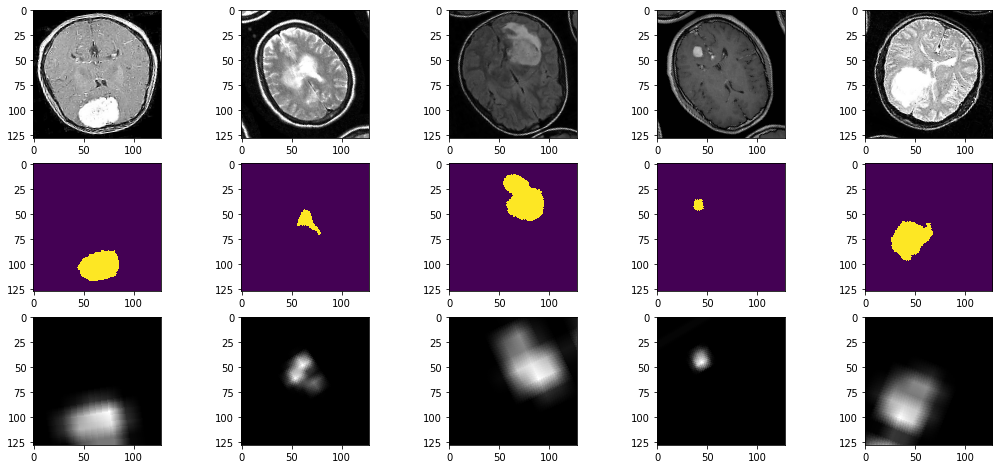

In [ ]:
plt.figure(figsize =(18, 8))
posi = 1
for i in random.sample(range(0, 500), 5):
    data = train_dataset[i]
    img = data['image']
    ax = plt.subplot(3, 5, posi)
    ax.imshow(img.permute(1, 2, 0))

    mask = data['mask']
    ax = plt.subplot(3, 5, posi + 5)
    # ax.imshow((mask * img.numpy()).transpose(1, 2, 0))
    ax.imshow(mask)

    cam = np.squeeze(data['cam'])
    # visualization = show_cam_on_image(img, cam, use_rgb=True
    # plt.imshow(img_array, cmap='gray')
    ax = plt.subplot(3, 5, posi + 10)
    ax.imshow(cam, cmap='gray')
    posi += 1


# Model

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Att(nn.Module):
  """Downscaling CAM and calculate attention score"""
  def __init__(self, in_channels, out_channels):
    super(Att, self).__init__()
    self.filters = out_channels
    self.model = nn.Sequential(
        nn.Linear(in_channels, 2048),
        nn.ReLU(),
        nn.Linear(2048, out_channels),
        nn.Softmax(dim=1)
    )
  def forward(self, x):
    bs = x.shape[0]
    out = self.model(x.view(bs, -1)) * self.filters
    return out

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2, att=None):
        bs = x1.shape[0]
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1) # new Channel number = x1 channel number + x2.channel number
        if att is not None:
            x = x.view(bs, 128, -1)
            x = (att * x).view(bs, 128, 128, 128)
            x = F.relu(x)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNetCam(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNetCam, self).__init__()
        print("Initialize UNetCam")
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.inc_cam = DoubleConv(1, 16)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

        self.down_cam1 = Down(16, 32)
        self.down_cam2 = Down(32, 64)
        self.down_cam3 = Down(64, 128)
        self.down_cam4 = Down(128, 64)
        self.attention = Att(4096, 128)

    def forward(self, x, cam):
        bs, _, _, _ = x.shape
        x1 = self.inc(x) # [BS, 64, 128, 128]
        x2 = self.down1(x1) # [BS, 128, 64, 64]
        x3 = self.down2(x2) # [BS, 256, 32, 32]
        x4 = self.down3(x3) # [BS, 512, 16, 16]
        x5 = self.down4(x4) # [BS, 1024, 8, 8]
        
        cam1 = self.inc_cam(cam)
        cam2 = self.down_cam1(cam1)
        cam3 = self.down_cam2(cam2)
        cam4 = self.down_cam3(cam3)
        cam5 = self.down_cam4(cam4)
        attention = self.attention(cam5).view(1, bs, 128, 1)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2).view(bs, 128, -1)
        # Apply attention to filters right before concat with original input
        x = (attention * x).view(bs, 128, 64, 64)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


# Trainer



In [ ]:
class Trainer:
  def __init__(self, model_path=None):

    self.model = UNetCam(3, 1).to(DEVICE)
    self.best_loss = 0.24

    if model_path is not None:
      self.model.load_state_dict(torch.load(model_path))

    self.optimizer = optim.Adam(self.model.parameters(),lr=1e-5, weight_decay=1e-5)
    
    #self.criterion = nn.BCELoss()
    self.criterion = nn.BCEWithLogitsLoss()

    self.accuracy = 0.0
    self.iou = 0.0
    self.train_loss = []
    self.val_loss = []
      
  def fit(self, train_loader):
    print('-------------Training---------------')
    self.model.train()
    train_running_loss = 0.0
    counter=0
    # num_batches = int(500 // BATCH_SIZE)
    for i, data in tqdm(enumerate(train_loader), total=500//32):
        counter+=1
        image = data["image"].to(DEVICE)
        mask = data["mask"].to(DEVICE).float()
        cam = data["cam"].to(DEVICE).float()
        self.optimizer.zero_grad()
    
        outputs = self.model(image, cam)

        outputs =outputs.squeeze(1)

        loss = self.criterion(outputs,mask)
        train_running_loss += loss.item()
        loss.backward()
        self.optimizer.step()
    train_loss = train_running_loss/counter
    return train_loss

  def validate(self, val_loader):
    print("\n--------Validating---------\n")
    self.model.eval()
    valid_running_loss = 0.0
    counter = 0

    with torch.no_grad():
        for i, val_data in enumerate(val_loader):
            counter+=1
            image = val_data["image"].to(DEVICE)
            mask = val_data["mask"].to(DEVICE).float()
            cam = val_data["cam"].to(DEVICE).float()
        
            outputs = self.model(image, cam)

            outputs =outputs.squeeze(1)
          
            loss = self.criterion(outputs,mask)

            valid_running_loss += loss.item()

    valid_loss = valid_running_loss/counter
    if valid_loss < self.best_loss:
      print("New Lower Val Loss: {:.2f} -> {:.2f}".format(self.best_loss, valid_loss))
      self.best_loss = valid_loss
      torch.save(self.model.state_dict(), f'/content/drive/My Drive/cam_unet.pt')
    return valid_loss

  def train(self, Epochs, train_loader, val_loader):
    for epoch in range(Epochs):
      print(f"Epoch {epoch+1} of {Epochs}")
      train_epoch_loss = self.fit(train_loader)
      val_epoch_loss = self.validate(val_loader)
      self.train_loss.append(train_epoch_loss)
      self.val_loss.append(val_epoch_loss)
      print(f"Train Loss: {train_epoch_loss:.4f}")
      print(f'Val Loss: {val_epoch_loss:.4f}')

  def trainlog(self):
    plt.figure(figsize =(10, 8))
    plt.plot(self.train_loss, label="train loss")
    plt.plot(self.val_loss, label="val loss")

  def test(self, test_loader):
    counter = 0
    self.accuracy = 0.0
    self.iou = 0.0

    with torch.no_grad():
      for i, data in enumerate(test_loader):
          counter+=1
          image = data["image"].to(DEVICE)
          mask = data["mask"].to(DEVICE).float()
          cam = data["cam"].to(DEVICE).float()
  
          outputs = self.model(image, cam)
     
          outputs =outputs.squeeze(1)
          outputs[outputs>0.0] = 1.0
          outputs[outputs<=0.0] = 0.0

          correct = torch.sum(outputs == mask)
          self.accuracy += correct / (BATCH_SIZE * 128 * 128)

          tp = torch.sum(outputs * mask)
          self.iou += tp / (outputs.sum() + mask.sum() - tp)

    self.accuracy /= counter
    self.iou /= counter

    print("Acc: ", self.accuracy)
    print("IOU: ", self.iou)

  def visualize(self, test_dataset):
    plt.figure(figsize =(18, 8))
    posi = 1
    for i in random.sample(range(1, 100), 5):
      data = test_dataset[i]
      image = data['image']
      mask = data['mask']
  
      ax = plt.subplot(3, 5, posi)
      ax.imshow(image.permute(1, 2, 0))
      ax = plt.subplot(3, 5, posi+5)
      ax.imshow(mask)
  
      ax = plt.subplot(3, 5, posi+10)
      img = data["image"].unsqueeze(0).to(DEVICE)
      cam = torch.tensor(data["cam"], dtype=torch.float32).unsqueeze(0).to(DEVICE)

      output = self.model(img, cam)
      
      output = torch.squeeze(output)
      output[output>0.0] = 1.0
      output[output<=0.0]=0
      ax.imshow(output.cpu().detach().numpy())
      posi += 1

Initialize UNetCam
Epoch 1 of 60
-------------Training---------------


16it [00:23,  1.49s/it]



--------Validating---------

Train Loss: 0.6501
Val Loss: 0.6703
Epoch 2 of 60
-------------Training---------------


16it [00:23,  1.44s/it]



--------Validating---------

Train Loss: 0.6037
Val Loss: 0.6413
Epoch 3 of 60
-------------Training---------------


16it [00:23,  1.44s/it]



--------Validating---------

Train Loss: 0.5630
Val Loss: 0.5857
Epoch 4 of 60
-------------Training---------------


16it [00:23,  1.44s/it]



--------Validating---------

Train Loss: 0.5138
Val Loss: 0.5477
Epoch 5 of 60
-------------Training---------------


16it [00:23,  1.46s/it]



--------Validating---------

Train Loss: 0.4746
Val Loss: 0.5319
Epoch 6 of 60
-------------Training---------------


16it [00:23,  1.46s/it]



--------Validating---------

Train Loss: 0.4456
Val Loss: 0.4766
Epoch 7 of 60
-------------Training---------------


16it [00:23,  1.44s/it]



--------Validating---------

Train Loss: 0.4238
Val Loss: 0.4387
Epoch 8 of 60
-------------Training---------------


16it [00:23,  1.45s/it]



--------Validating---------

Train Loss: 0.4066
Val Loss: 0.3975
Epoch 9 of 60
-------------Training---------------


16it [00:23,  1.44s/it]



--------Validating---------

Train Loss: 0.3897
Val Loss: 0.3898
Epoch 10 of 60
-------------Training---------------


16it [00:23,  1.47s/it]



--------Validating---------

Train Loss: 0.3808
Val Loss: 0.3708
Epoch 11 of 60
-------------Training---------------


16it [00:23,  1.45s/it]



--------Validating---------

Train Loss: 0.3685
Val Loss: 0.3616
Epoch 12 of 60
-------------Training---------------


16it [00:23,  1.44s/it]



--------Validating---------

Train Loss: 0.3598
Val Loss: 0.3606
Epoch 13 of 60
-------------Training---------------


16it [00:23,  1.46s/it]



--------Validating---------

Train Loss: 0.3538
Val Loss: 0.3495
Epoch 14 of 60
-------------Training---------------


16it [00:23,  1.46s/it]



--------Validating---------

Train Loss: 0.3494
Val Loss: 0.3453
Epoch 15 of 60
-------------Training---------------


16it [00:23,  1.45s/it]



--------Validating---------

Train Loss: 0.3416
Val Loss: 0.3413
Epoch 16 of 60
-------------Training---------------


16it [00:23,  1.45s/it]



--------Validating---------

Train Loss: 0.3395
Val Loss: 0.3371
Epoch 17 of 60
-------------Training---------------


16it [00:23,  1.45s/it]



--------Validating---------

Train Loss: 0.3364
Val Loss: 0.3363
Epoch 18 of 60
-------------Training---------------


16it [00:23,  1.45s/it]



--------Validating---------

Train Loss: 0.3307
Val Loss: 0.3278
Epoch 19 of 60
-------------Training---------------


16it [00:23,  1.47s/it]



--------Validating---------

Train Loss: 0.3267
Val Loss: 0.3226
Epoch 20 of 60
-------------Training---------------


16it [00:23,  1.45s/it]



--------Validating---------

Train Loss: 0.3237
Val Loss: 0.3358
Epoch 21 of 60
-------------Training---------------


16it [00:23,  1.44s/it]



--------Validating---------

Train Loss: 0.3206
Val Loss: 0.3233
Epoch 22 of 60
-------------Training---------------


16it [00:23,  1.44s/it]



--------Validating---------

Train Loss: 0.3182
Val Loss: 0.3148
Epoch 23 of 60
-------------Training---------------


16it [00:23,  1.47s/it]



--------Validating---------

Train Loss: 0.3144
Val Loss: 0.3105
Epoch 24 of 60
-------------Training---------------


16it [00:23,  1.44s/it]



--------Validating---------

Train Loss: 0.3118
Val Loss: 0.3333
Epoch 25 of 60
-------------Training---------------


16it [00:23,  1.45s/it]



--------Validating---------

Train Loss: 0.3088
Val Loss: 0.3064
Epoch 26 of 60
-------------Training---------------


16it [00:22,  1.44s/it]



--------Validating---------

Train Loss: 0.3072
Val Loss: 0.3085
Epoch 27 of 60
-------------Training---------------


16it [00:23,  1.44s/it]



--------Validating---------

Train Loss: 0.3059
Val Loss: 0.3075
Epoch 28 of 60
-------------Training---------------


16it [00:23,  1.46s/it]



--------Validating---------

Train Loss: 0.3063
Val Loss: 0.3051
Epoch 29 of 60
-------------Training---------------


16it [00:22,  1.44s/it]



--------Validating---------

Train Loss: 0.3024
Val Loss: 0.3010
Epoch 30 of 60
-------------Training---------------


16it [00:22,  1.44s/it]



--------Validating---------

Train Loss: 0.3004
Val Loss: 0.3070
Epoch 31 of 60
-------------Training---------------


16it [00:23,  1.46s/it]



--------Validating---------

Train Loss: 0.2996
Val Loss: 0.3015
Epoch 32 of 60
-------------Training---------------


16it [00:23,  1.45s/it]



--------Validating---------

Train Loss: 0.2959
Val Loss: 0.3016
Epoch 33 of 60
-------------Training---------------


16it [00:23,  1.45s/it]



--------Validating---------

Train Loss: 0.2947
Val Loss: 0.3000
Epoch 34 of 60
-------------Training---------------


16it [00:23,  1.47s/it]



--------Validating---------

Train Loss: 0.2923
Val Loss: 0.2963
Epoch 35 of 60
-------------Training---------------


16it [00:23,  1.45s/it]



--------Validating---------

Train Loss: 0.2912
Val Loss: 0.2912
Epoch 36 of 60
-------------Training---------------


16it [00:23,  1.49s/it]



--------Validating---------

Train Loss: 0.2907
Val Loss: 0.2921
Epoch 37 of 60
-------------Training---------------


16it [00:24,  1.51s/it]



--------Validating---------

Train Loss: 0.2880
Val Loss: 0.2902
Epoch 38 of 60
-------------Training---------------


16it [00:23,  1.46s/it]



--------Validating---------

Train Loss: 0.2870
Val Loss: 0.2888
Epoch 39 of 60
-------------Training---------------


16it [00:23,  1.45s/it]



--------Validating---------

Train Loss: 0.2852
Val Loss: 0.3043
Epoch 40 of 60
-------------Training---------------


16it [00:22,  1.44s/it]



--------Validating---------

Train Loss: 0.2839
Val Loss: 0.2856
Epoch 41 of 60
-------------Training---------------


16it [00:23,  1.46s/it]



--------Validating---------

Train Loss: 0.2836
Val Loss: 0.2876
Epoch 42 of 60
-------------Training---------------


16it [00:23,  1.45s/it]



--------Validating---------

Train Loss: 0.2811
Val Loss: 0.2895
Epoch 43 of 60
-------------Training---------------


16it [00:22,  1.43s/it]



--------Validating---------

Train Loss: 0.2798
Val Loss: 0.2882
Epoch 44 of 60
-------------Training---------------


16it [00:23,  1.44s/it]



--------Validating---------

Train Loss: 0.2790
Val Loss: 0.2929
Epoch 45 of 60
-------------Training---------------


16it [00:23,  1.46s/it]



--------Validating---------

Train Loss: 0.2779
Val Loss: 0.2864
Epoch 46 of 60
-------------Training---------------


16it [00:23,  1.47s/it]



--------Validating---------

Train Loss: 0.2760
Val Loss: 0.2907
Epoch 47 of 60
-------------Training---------------


16it [00:23,  1.47s/it]



--------Validating---------

Train Loss: 0.2749
Val Loss: 0.2993
Epoch 48 of 60
-------------Training---------------


16it [00:23,  1.45s/it]



--------Validating---------

Train Loss: 0.2740
Val Loss: 0.2817
Epoch 49 of 60
-------------Training---------------


16it [00:23,  1.45s/it]



--------Validating---------

Train Loss: 0.2723
Val Loss: 0.2779
Epoch 50 of 60
-------------Training---------------


16it [00:23,  1.46s/it]



--------Validating---------

Train Loss: 0.2713
Val Loss: 0.2756
Epoch 51 of 60
-------------Training---------------


16it [00:23,  1.46s/it]



--------Validating---------

Train Loss: 0.2702
Val Loss: 0.2844
Epoch 52 of 60
-------------Training---------------


16it [00:23,  1.47s/it]



--------Validating---------

Train Loss: 0.2694
Val Loss: 0.2853
Epoch 53 of 60
-------------Training---------------


16it [00:23,  1.48s/it]



--------Validating---------

Train Loss: 0.2686
Val Loss: 0.2719
Epoch 54 of 60
-------------Training---------------


16it [00:23,  1.46s/it]



--------Validating---------

Train Loss: 0.2670
Val Loss: 0.2712
Epoch 55 of 60
-------------Training---------------


16it [00:23,  1.47s/it]



--------Validating---------

Train Loss: 0.2676
Val Loss: 0.2717
Epoch 56 of 60
-------------Training---------------


16it [00:23,  1.46s/it]



--------Validating---------

Train Loss: 0.2648
Val Loss: 0.2748
Epoch 57 of 60
-------------Training---------------


16it [00:23,  1.46s/it]



--------Validating---------

Train Loss: 0.2633
Val Loss: 0.2708
Epoch 58 of 60
-------------Training---------------


16it [00:23,  1.45s/it]



--------Validating---------

Train Loss: 0.2627
Val Loss: 0.2713
Epoch 59 of 60
-------------Training---------------


16it [00:23,  1.47s/it]



--------Validating---------

Train Loss: 0.2609
Val Loss: 0.2690
Epoch 60 of 60
-------------Training---------------


16it [00:23,  1.46s/it]



--------Validating---------

Train Loss: 0.2602
Val Loss: 0.2634


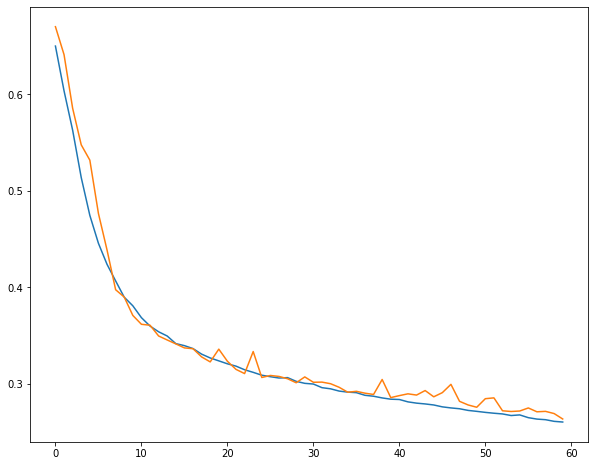

In [ ]:
torch.cuda.empty_cache()

train_cam = Trainer()
train_cam.train(Epochs=60, train_loader=train_dataloader, val_loader=val_dataloader)
train_cam.trainlog()

In [ ]:
train_cam.test(test_loader=test_dataloader)

Acc:  tensor(0.7655, device='cuda:0')
IOU:  tensor(0.7121, device='cuda:0')


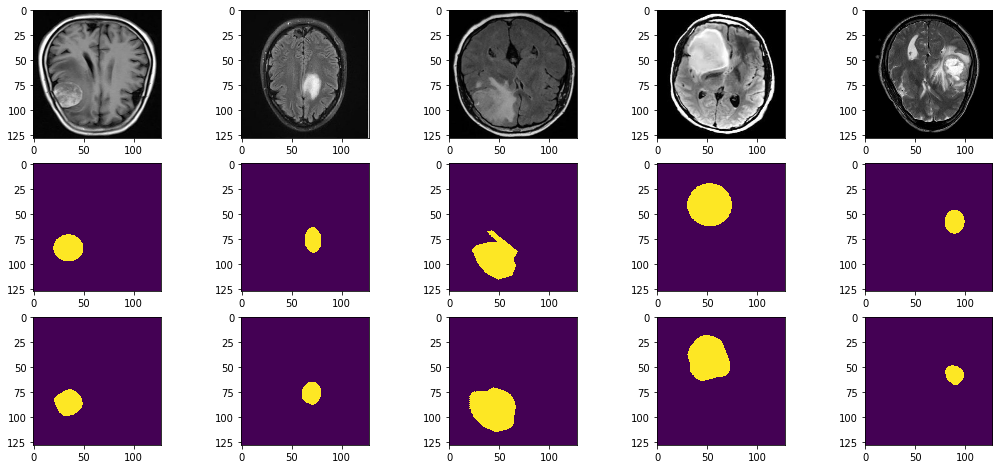

In [ ]:
train_cam.visualize(test_dataset)

In [ ]:
plt.figure(figsize =(18, 8))
posi = 1

model_cam = UNetCam(3, 1).to(DEVICE)

model_cam.load_state_dict(torch.load("/content/drive/My Drive/cam_unet.pt"))


for i in range(0, 100):
    data = test_dataset[i]
    image = data['image']
    img = data["image"].unsqueeze(0).to(DEVICE)

 
    
    mask = data['mask']

    cam = torch.tensor(data["cam"], dtype=torch.float32).unsqueeze(0).to(DEVICE)
    out_cam = model_cam(img, cam)
    out_cam = torch.squeeze(out_cam)
    out_cam[out_cam>0.0] = 1.0
    out_cam[out_cam<=0.0]=0
    plt.imshow(out_cam.cpu().detach().numpy())
    plt.savefig(os.path.join(root_folder, "Results_test/y"+str(i+701)+".png"))


Initialize UNetCam
